# Introduction

This project aims to train a classification model that can predict if a user will accept a coupon given his/her answers to some survey questions. 
The attributes of the data set include:

This data was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. For more information about the dataset, please refer to the paper: 
Wang, Tong, Cynthia Rudin, Finale Doshi-Velez, Yimin Liu, Erica Klampfl, and Perry MacNeille. 'A bayesian framework for learning rule sets for interpretable classification.' The Journal of Machine Learning Research 18, no. 1 (2017): 2357-2393.

**User attributes**
* gender: male, female
* age: 21, 46, 26, 31, 41, 50plus, 36, below21
* maritalStatus: Unmarried partner, Single, Married partner, Divorced, Widowed 
* has_Children:1, 0 
* education: Some college - no degree, Bachelors degree, Associates degree, High School Graduate, Graduate degree (Masters or Doctorate), Some High School
* occupation: Unemployed, Architecture & Engineering, Student, Education&Training&Library, Healthcare Support, Healthcare Practitioners & Technical, Sales & Related, Management, Arts Design Entertainment Sports & Media, Computer & Mathematical, Life Physical Social Science, Personal Care & Service, Community & Social Services, Office & Administrative Support, Construction & Extraction, Legal, Retired, Installation Maintenance & Repair, Transportation & Material Moving, Business & Financial, Protective Service, Food Preparation & Serving Related, Production Occupations, Building & Grounds Cleaning & Maintenance, Farming Fishing & Forestry 
* income: \\$37500 - \\$49999, \\$62500 - \\$74999, \\$12500 - \\$24999, \\$75000 - \\$87499, \\$50000 - \\$62499, \\$25000 - \\$37499, \\$100000 or More, \\$87500 - \\$99999, Less than \\$12500 
* Bar: never, less1, 1\~3, gt8, nan4\~8 (feature meaning: how many times do you go to a bar every month?) 
* CoffeeHouse: never, less1, 4\~8, 1\~3, gt8, nan (feature meaning: how many times do you go to a coffeehouse every month?)
* CarryAway:n4\~8, 1\~3, gt8, less1, never (feature meaning: how many times do you get take-away food every month?) 
* RestaurantLessThan20: 4\~8, 1\~3, less1, gt8, never (feature meaning: how many times do you go to a restaurant with an average expense per person of less than \\$20 every month?) 
* Restaurant20To50: 1\~3, less1, never, gt8, 4\~8, nan (feature meaning: how many times do you go to a restaurant with average expense per person of \\$20 - \\$50 every month?) 

**Contextual attributes**
* destination: No Urgent Place, Home, Work 
* passanger: Alone, Friend(s), Kid(s), Partner (who are the passengers in the car)
* weather: Sunny, Rainy, Snowy 
* temperature:55, 80, 30 
* time: 2PM, 10AM, 6PM, 7AM, 10PM 
* toCoupon_GEQ5min:0, 1 (feature meaning: driving distance to the restaurant/bar for using the coupon is greater than 5 minutes) 
* toCoupon_GEQ15min:0,1 (feature meaning: driving distance to the restaurant/bar for using the coupon is greater than 15 minutes) 
* toCoupon_GEQ25min:0, 1 (feature meaning: driving distance to the restaurant/bar for using the coupon is greater than 25 minutes) 
* direction_same:0, 1 (feature meaning: whether the restaurant/bar is in the same direction as your current destination) 
* direction_opp:1, 0 (feature meaning: whether the restaurant/bar is in the same direction as your current destination) 

**Coupon attributes**
* coupon: Restaurant(<\\$20), Coffee House, Carry out & Take away, Bar, Restaurant(\\$20-\\$50) 
* expiration: 1d, 2h (the coupon expires in 1 day or in 2 hours) 

# Data Importing

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scikitplot as skplt
import missingno as msno
import xgboost as xgb
import lightgbm as lgb
import wandb
import plotly.graph_objects as go

from collections import defaultdict
from matplotlib.ticker import FixedLocator, FixedFormatter
from joblib import dump, load
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, \
RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.decomposition import PCA, KernelPCA
from kmodes.kmodes import KModes
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier, Pool
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
# from flaml import AutoML

In [2]:
df = pd.read_csv('/kaggle/input/invehicle-coupon-recommendation/in-vehicle-coupon-recommendation.csv')

# Data Wrangling

In [3]:
# Ultimate Data Processing Function
def data_cleaning(data=df):
    clean_df = df.copy()
    
    clean_df.drop(columns=['car'], inplace=True)
    na_columns = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
    clean_df.drop(columns=['toCoupon_GEQ5min'], inplace=True)
    clean_df[na_columns] = clean_df[na_columns].fillna(clean_df[na_columns].mode().iloc[0])
    frequency_map = {
        'never': 0,
        'less1': 1,
        '1~3': 2,
        '4~8': 3,
        'gt8': 4}
    age_map = {
        'below21': 0,
        '21': 1,
        '26': 2,
        '31': 3,
        '36': 4,
        '41': 5,
        '46': 6,
        '50plus': 7}
    income_map = {
        'Less than $12500': 0,
        '$12500 - $24999': 1,
        '$25000 - $37499': 2,
        '$37500 - $49999': 3,
        '$50000 - $62499': 4,
        '$62500 - $74999': 5,
        '$75000 - $87499': 6,
        '$87500 - $99999': 7,
        '$100000 or More': 8}
    edu_map = {
        'Some High School': 0,
        'High School Graduate': 1,
        'Some college - no degree': 2,
        'Associates degree': 3,
        'Bachelors degree': 4,
        'Graduate degree (Masters or Doctorate)': 5}
    frequency_cols = ['Restaurant20To50', 'RestaurantLessThan20', 
                      'CarryAway', 'CoffeeHouse', 'Bar']
    for col in frequency_cols:
        clean_df[col] = clean_df[col].map(frequency_map)
    clean_df.age = clean_df.age.map(age_map)
    clean_df.income = clean_df.income.map(income_map)
    clean_df.education = clean_df.education.map(edu_map)
    clean_df.drop(columns=['direction_opp'], inplace=True)
    clean_df['distance'] = None
    clean_df.loc[clean_df['toCoupon_GEQ15min'] == 0, 'distance'] = 0
    clean_df.loc[(clean_df['toCoupon_GEQ15min'] == 1) & \
                 (clean_df['toCoupon_GEQ25min'] == 0), 'distance'] = 1
    clean_df.loc[clean_df['toCoupon_GEQ25min'] == 1, 'distance'] = 2
    clean_df.distance = clean_df.distance.astype('int64')
    clean_df.drop(columns=['toCoupon_GEQ15min', 'toCoupon_GEQ25min'], inplace=True)
    clean_df.has_children = clean_df.has_children.astype(str)
    clean_df.direction_same = clean_df.direction_same.astype(str)
    return clean_df

In [4]:
# clean_df = data_cleaning(df)
# clean_df.shape

In [5]:
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

**Car**

There are some missing values in several columns, and the 'car' variable has only 108 non-null values, more than 99% of the values are NaN. We can just drop it off. Before doing that, let's have a look of the non-null values in 'car' column.

In [7]:
print(df.car.unique())

[nan 'Scooter and motorcycle' 'crossover' 'Mazda5' 'do not drive'
 'Car that is too old to install Onstar :D']


No much information left in the 'car' variable, we can just drop it off.

In [8]:
df.drop(columns=['car'], inplace=True)

Now, check missing values of other columns:

**Missing Values**

In [9]:
df.isna().sum()

destination               0
passanger                 0
weather                   0
temperature               0
time                      0
coupon                    0
expiration                0
gender                    0
age                       0
maritalStatus             0
has_children              0
education                 0
occupation                0
income                    0
Bar                     107
CoffeeHouse             217
CarryAway               151
RestaurantLessThan20    130
Restaurant20To50        189
toCoupon_GEQ5min          0
toCoupon_GEQ15min         0
toCoupon_GEQ25min         0
direction_same            0
direction_opp             0
Y                         0
dtype: int64

There are five more columns with missing values, and all of them have data type 'object', which means they are all strings. Time to do some missing value visualizations:

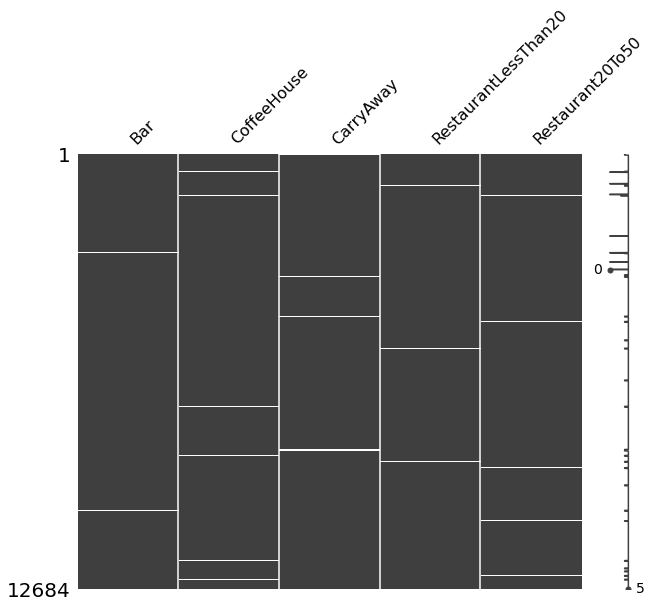

In [10]:
na_columns = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
na_df = df[na_columns]
msno.matrix(na_df, figsize=(10, 8))
plt.show()

From this matrix, we can probably say the missing values are at least missing at random. Let's do a correlation heatmap to ensure that.

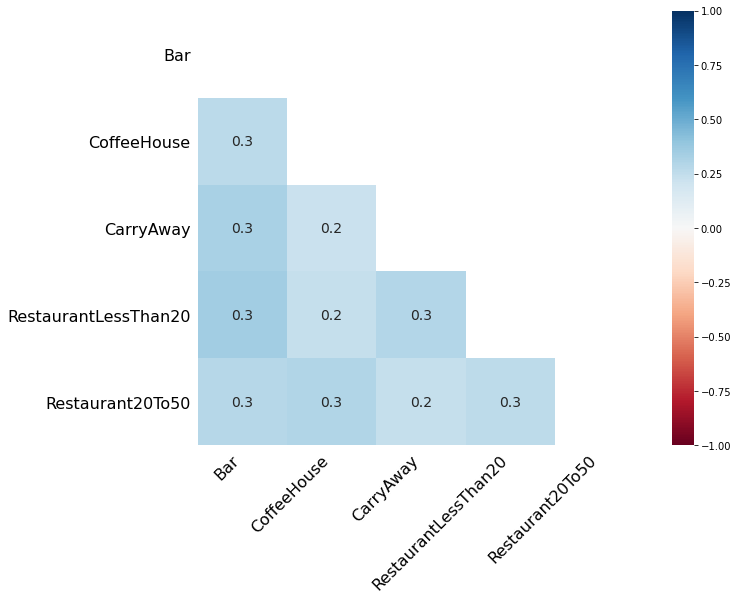

In [11]:
msno.heatmap(na_df, figsize=(10, 8));

Indeed, missing at random. So, we are ready to start data imputation now. Before that, let's explore the dataset a little more.

In [12]:
df.describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
df.select_dtypes('int64').nunique()

temperature          3
has_children         2
toCoupon_GEQ5min     1
toCoupon_GEQ15min    2
toCoupon_GEQ25min    2
direction_same       2
direction_opp        2
Y                    2
dtype: int64

Well, the column 'toCoupon_GEQ5min' has only one single value: 1. No variance at all, so, we can drop it. According to the dataset description, this column means driving distance to the restaurant/bar for using the coupon is greater than 5 minutes, so all the restaurant/bars are at least five minutes away from the driver.

**toCoupon_GEQ5min**

In [14]:
df.drop(columns=['toCoupon_GEQ5min'], inplace=True)

In [15]:
df.select_dtypes('object').nunique()

destination              3
passanger                4
weather                  3
time                     5
coupon                   5
expiration               2
gender                   2
age                      8
maritalStatus            5
education                6
occupation              25
income                   9
Bar                      5
CoffeeHouse              5
CarryAway                5
RestaurantLessThan20     5
Restaurant20To50         5
dtype: int64

In [16]:
for i in df.select_dtypes('object').columns:
    print(i, df[i].unique())

destination ['No Urgent Place' 'Home' 'Work']
passanger ['Alone' 'Friend(s)' 'Kid(s)' 'Partner']
weather ['Sunny' 'Rainy' 'Snowy']
time ['2PM' '10AM' '6PM' '7AM' '10PM']
coupon ['Restaurant(<20)' 'Coffee House' 'Carry out & Take away' 'Bar'
 'Restaurant(20-50)']
expiration ['1d' '2h']
gender ['Female' 'Male']
age ['21' '46' '26' '31' '41' '50plus' '36' 'below21']
maritalStatus ['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed']
education ['Some college - no degree' 'Bachelors degree' 'Associates degree'
 'High School Graduate' 'Graduate degree (Masters or Doctorate)'
 'Some High School']
occupation ['Unemployed' 'Architecture & Engineering' 'Student'
 'Education&Training&Library' 'Healthcare Support'
 'Healthcare Practitioners & Technical' 'Sales & Related' 'Management'
 'Arts Design Entertainment Sports & Media' 'Computer & Mathematical'
 'Life Physical Social Science' 'Personal Care & Service'
 'Community & Social Services' 'Office & Administrative Support'
 'Constr

For the missing data imputation, we are gonna replace missing values with the most frequent category, as we've checked all the columns with missing values have categorical data.

In [17]:
df[na_columns] = df[na_columns].fillna(df[na_columns].mode().iloc[0])

In [18]:
df.isna().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
Y                       0
dtype: int64

Now, we have finished the basic data wrangling part with no more missing values in our dataset, if other problems rises during exploratory data analysis, we can repeat the data wrangling process.

In [19]:
clean_df = df.copy()

# Exploratory Data Analysis

First, we plot the count plot of each categorical variable:

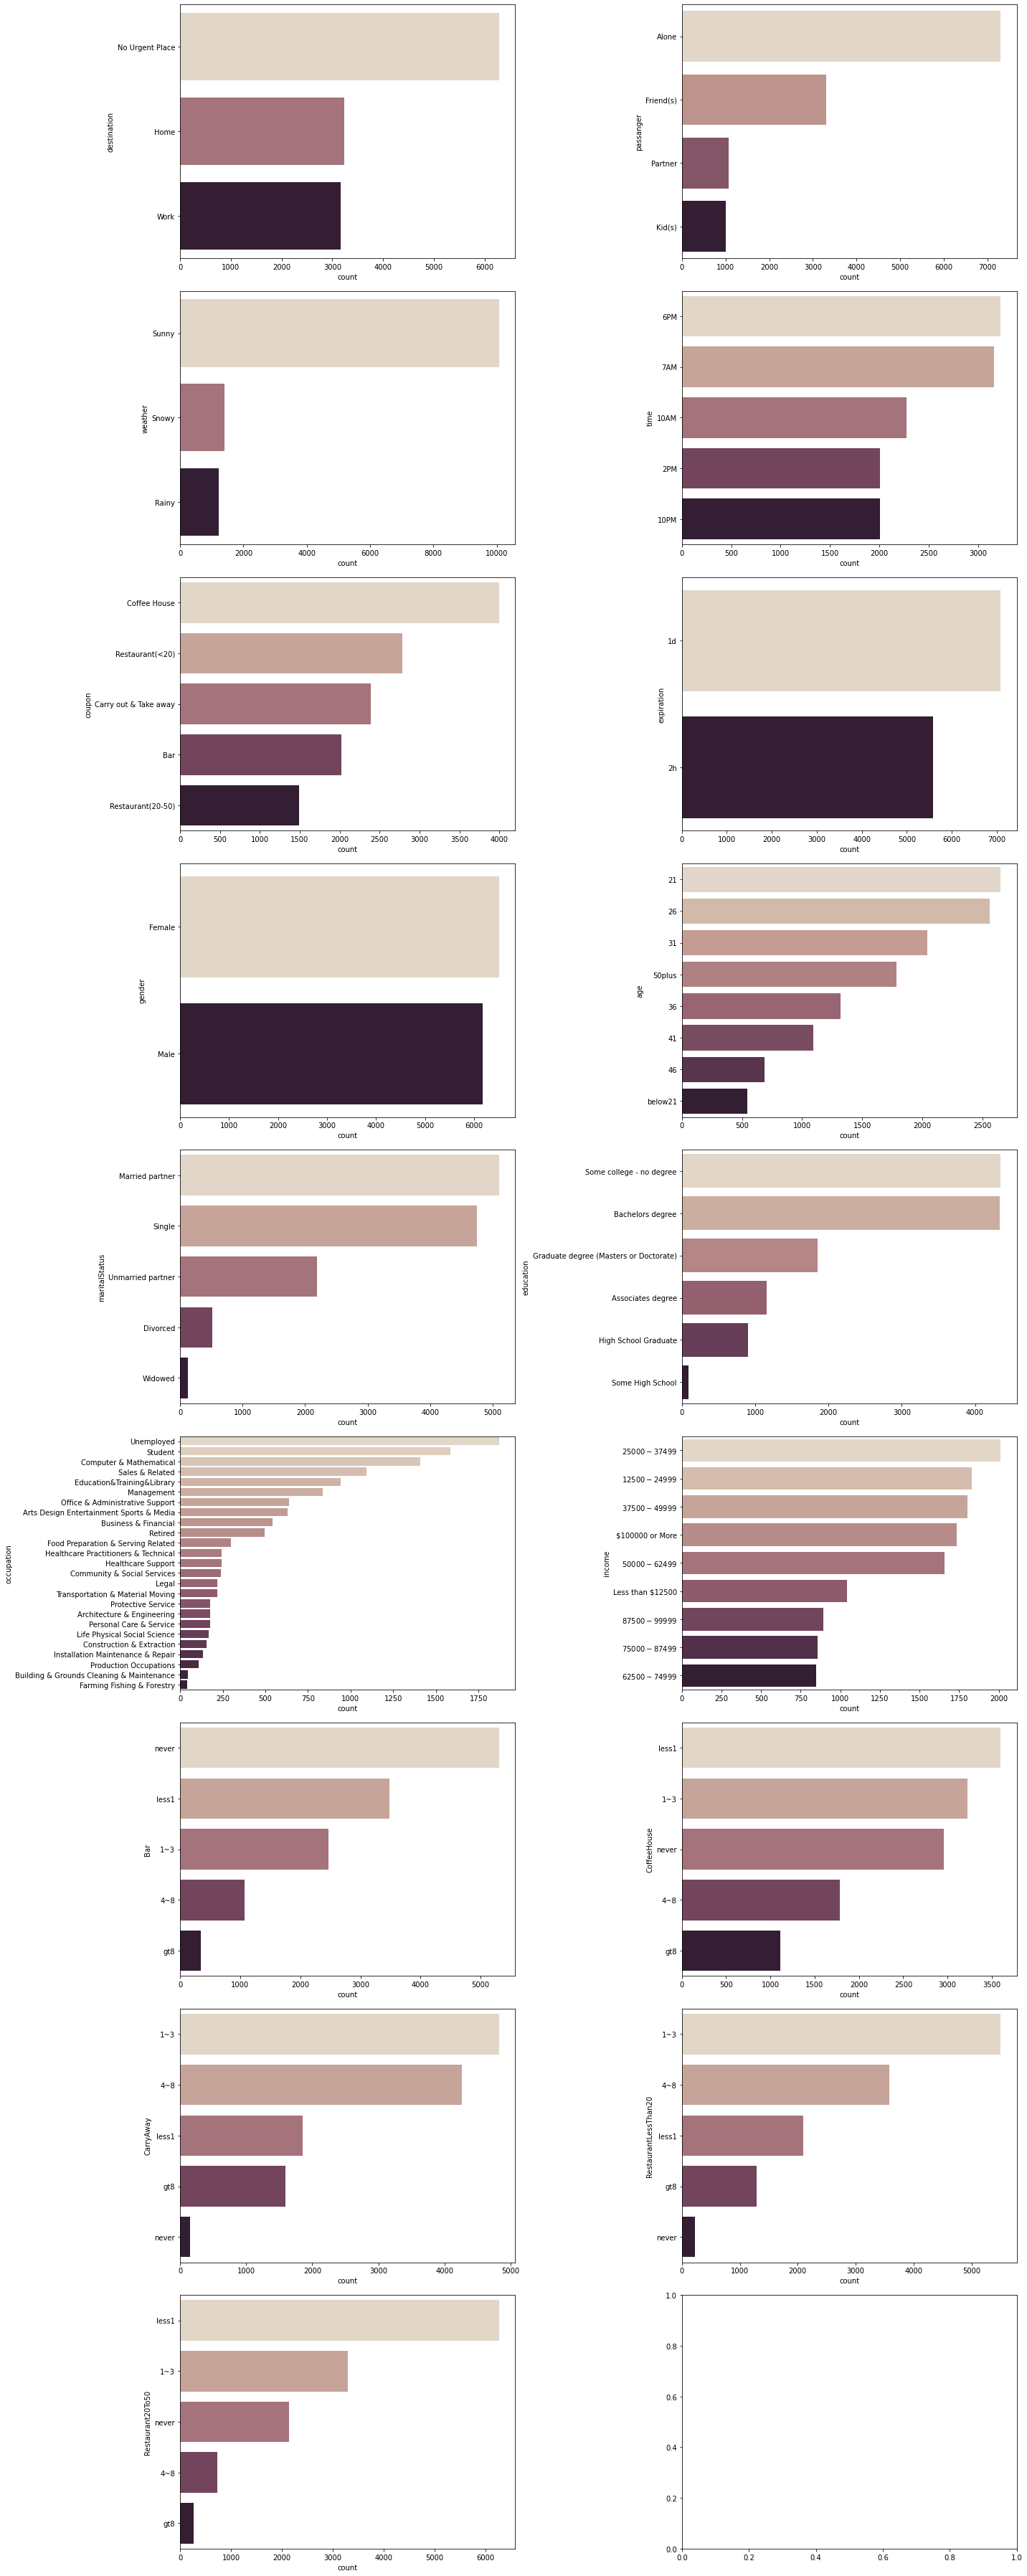

In [20]:
fig, axes = plt.subplots(9, 2, figsize=(20,50))
axes = axes.flatten()

for ax, col in zip(axes, clean_df.select_dtypes('object').columns):
    sns.countplot(y=col, data=clean_df, ax=ax, 
                  palette="ch:.25", order=clean_df[col].value_counts().index);

plt.tight_layout()
plt.show()

By looking at the counting plot of the categorical features, we realized that there are two kinds of categorical data: ordinal and nominal, we can apply one hot encoder to nominal features, however, ordinal data should be mapped into numerical data so that the inner order can preserve.

Those ordinal features are: 

* **Restaurant20To50**: how many times do you go to a restaurant with average expense per person of \\$20 - \\$50 every month?
* **RestaurantLessThan20**: how many times do you go to a restaurant with an average expense per person of less than \\$20 every month?
* **CarryAway**: how many times do you get take-away food every month?
* **CoffeeHouse**: how many times do you go to a coffeehouse every month?
* **age**: quite self-explanatory
* **Bar**: how many times do you go to bar every month?
* **income**: income range
* **education**: education level

Now, let's map them into numerical values with respect to their inner order:

In [21]:
frequency_map = {
    'never': 0,
    'less1': 1,
    '1~3': 2,
    '4~8': 3,
    'gt8': 4
}
age_map = {
    'below21': 0,
    '21': 1,
    '26': 2,
    '31': 3,
    '36': 4,
    '41': 5,
    '46': 6,
    '50plus': 7
}
income_map = {
    'Less than $12500': 0,
    '$12500 - $24999': 1,
    '$25000 - $37499': 2,
    '$37500 - $49999': 3,
    '$50000 - $62499': 4,
    '$62500 - $74999': 5,
    '$75000 - $87499': 6,
    '$87500 - $99999': 7,
    '$100000 or More': 8
}
edu_map = {
    'Some High School': 0,
    'High School Graduate': 1,
    'Some college - no degree': 2,
    'Associates degree': 3,
    'Bachelors degree': 4,
    'Graduate degree (Masters or Doctorate)': 5
}

In [22]:
frequency_cols = ['Restaurant20To50', 'RestaurantLessThan20', 
                  'CarryAway', 'CoffeeHouse', 'Bar']

In [23]:
for col in frequency_cols:
    clean_df[col] = clean_df[col].map(frequency_map)
clean_df.age = clean_df.age.map(age_map)
clean_df.income = clean_df.income.map(income_map)
clean_df.education = clean_df.education.map(edu_map)

We can check the correlations among all the numerical features now:

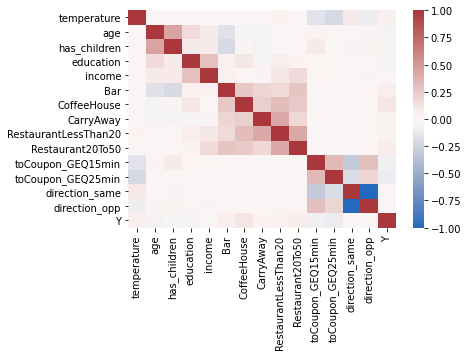

In [24]:
cmap = sns.color_palette('vlag', as_cmap=True)
sns.heatmap(clean_df.select_dtypes('int64', 'float64').corr(), cmap=cmap)
plt.show()

As the heatmap shows, there are two columns sharing the same information: **direction_same** and **direction_opp**. They indicate whether the restaurant/bar is in the same direction as your current destination. So we decide to delete the **direction_opp** column.

Besides, there are correlations among those frequency columns: **Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50**.

In [25]:
clean_df.drop(columns=['direction_opp'], inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


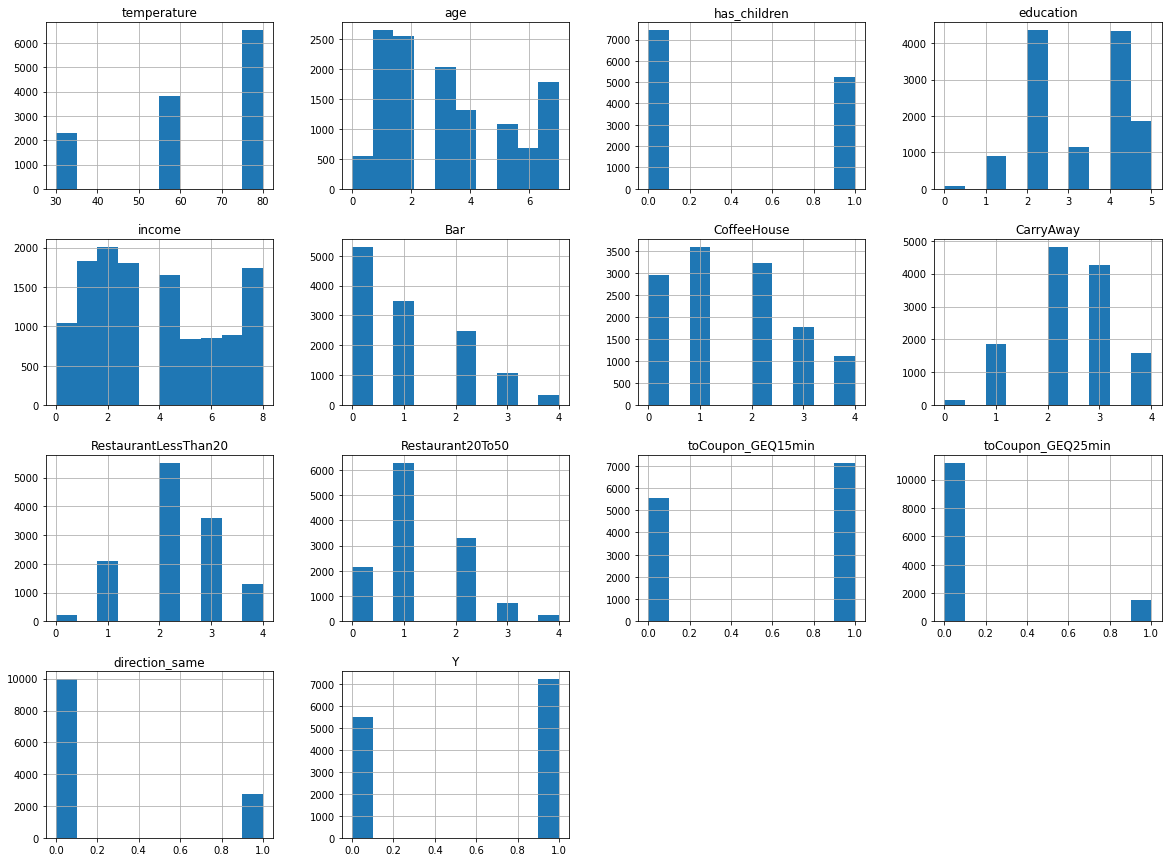

In [26]:
clean_df.hist(figsize=(20, 15))
plt.show()

**toCoupon_GEQ15min, toCoupon_GEQ25min**

After excluding the toCoupon_GEDQ5min feature, we see there are still two features about the driving distance to the Coupon's location: **toCoupon_GEQ15min** and **toCoupon_GEQ25min**. They have two possible values: 0 and 1 indicating yes or no to the question: is the driving distance to the restaurant/bar for using the coupon is greater than 15 minutes/25 minutes? We should be able to combine these two columns into one with ordinal data inside: greater than 5 minutes and less than 15 minutes, greater than 15 minutes and less than 25 minutes, and greater than 25 minutes. We believe doing that should be better than treat those two columns using onehotencoder just like different categories.

In [27]:
clean_df['distance'] = None
clean_df.loc[clean_df['toCoupon_GEQ15min'] == 0, 'distance'] = 0
clean_df.loc[(clean_df['toCoupon_GEQ15min'] == 1) & \
             (clean_df['toCoupon_GEQ25min'] == 0), 'distance'] = 1
clean_df.loc[clean_df['toCoupon_GEQ25min'] == 1, 'distance'] = 2
clean_df.distance.isna().sum()

0

In [28]:
clean_df.distance = clean_df.distance.astype('int64')
clean_df.distance.unique()

array([0, 1, 2])

In [29]:
clean_df.distance.value_counts()

1    5611
0    5562
2    1511
Name: distance, dtype: int64

Now we can drop these two columns: toCoupon_GEQ15min and toCoupon_GEQ25min

In [30]:
clean_df.drop(columns=['toCoupon_GEQ15min', 'toCoupon_GEQ25min'], inplace=True)

In [31]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  int64 
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  int64 
 12  occupation            12684 non-null  object
 13  income                12684 non-null  int64 
 14  Bar                   12684 non-null  int64 
 15  CoffeeHouse           12684 non-null

Some columns needed to be transformed into categorical columns.

In [32]:
clean_df.has_children = clean_df.has_children.astype(str)
clean_df.direction_same = clean_df.direction_same.astype(str)

Let's have a look of the target feature:

In [33]:
clean_df.Y.value_counts()

1    7210
0    5474
Name: Y, dtype: int64

It's well balanced. Accuracy can be a good metric for model performance.

Let's explore relationships between some of the features and the target:

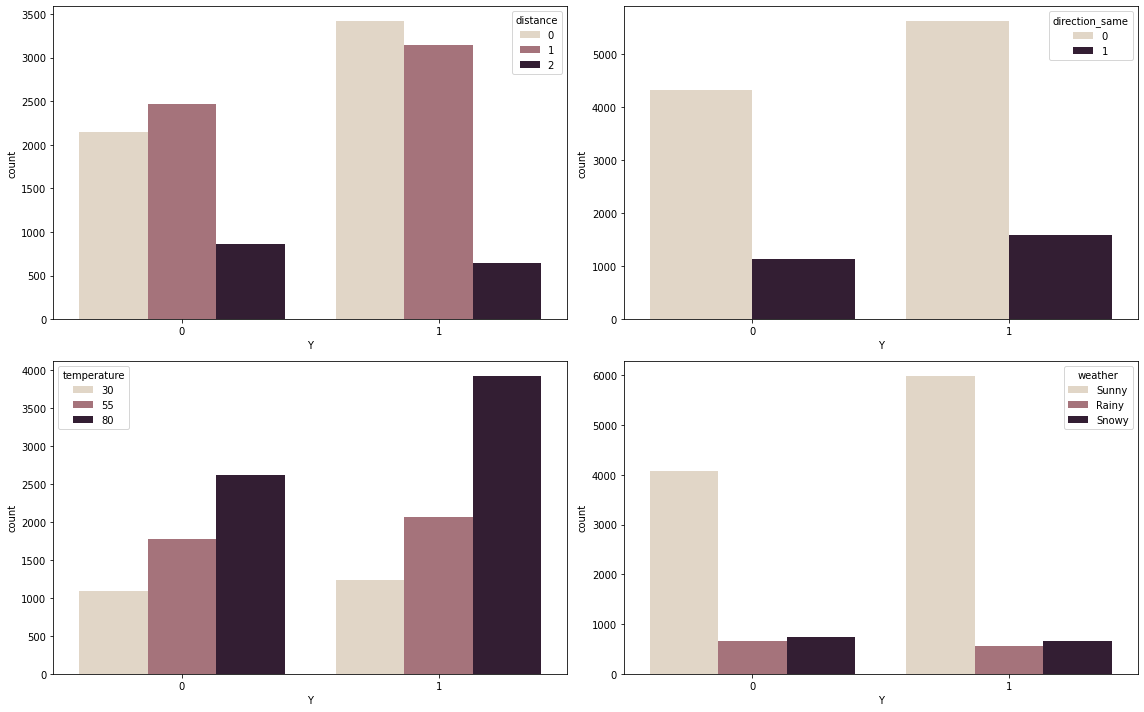

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for ax, col in zip(axes, ['distance', 'direction_same', 'temperature', 'weather']):
    sns.countplot(x="Y", hue=col, data=clean_df, 
                  ax=ax, palette="ch:.25");

plt.tight_layout()
plt.show()

The plot shows some subtle, positive correlations between short distance, same direction, high temperature, sunny weather and the probability to accept the coupon.

In [35]:
clean_df.shape

(12684, 22)

Now, with 21 features, we are ready to train classification models on the cleaned dataset.

In [36]:
# Save the cleaned data set
clean_df.to_csv('clean_df.csv', index=False)

In [37]:
# Notice the values of have_children and direction_same are 0 and 1
# Thus, if not specified, the pd.read_csv() method will infer them as integer
# clean_df = pd.read_csv('/kaggle/working/clean_df.csv', 
#                        dtype={'has_children': str,
#                              'direction_same': str})

# Model Training

## Data Preprocessing

Based on the exploratory data analysis, we have almost all categorical variables. Few of them can be combined into a meaningful new feature. For simplicity, all the categorical features left will be encoded using OneHotEncoder, since we are mainly using sklearn for model building.
One of a disadvantage of using OneHotEncoder is that it reduced the performance of decision trees and random forests, but RandomForestClassifier in sklearn only support numerical data.
There are other considerations about the feature engineering:
* do we need to apply dimension reduction?

After the OneHotEncoding, we can predict the number of features to reach 50 or more, and the frequency columns are correlated, so it is possible to apply dimension reduction methods like PCA. 
* do we need to apply feature expansion?

Manually adding meaningful new features on categorical data is hard, we can refer to kernel SVM to see the power of feature expansion. We are predicting the Gaussian RBF kernel will be better for this task than the polynomial kernel since most variables are categorical variables, similarity seems to be a better feature than polynomial transformations.

In [38]:
X = clean_df.drop(columns=['Y'])
y = clean_df.Y
X_train, X_test, y_train, y_test = \
train_test_split(X, y, random_state=0, test_size=0.2)

In [39]:
num_features = X_train.select_dtypes(['int64', 'float64']).columns
cat_features = X_train.select_dtypes(['object']).columns
full_pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(), cat_features)
])
X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

In [40]:
X_train.shape, X_test.shape

((10147, 68), (2537, 68))

After OneHotEncoding, we now have 66 features. Let's first try to build models without dimension reduction, and then re-train models after dimension reduction to see if there will be any improvement.

## Basic Models

### Logistic Regression

Let's start with no penalty.

#### no penalty

In [41]:
def model_eval(clf, X_test=X_test, y_test=y_test):
    y_pred = clf.predict(X_test)
    print("Mean cross-validated score of the best_estimator: {0:.3f}".format(clf.best_score_))
    print("Accuracy on test data: {0:.3f}".format(clf.score(X_test, y_test)))
    print(metrics.classification_report(y_test, y_pred))
    print("Tuned Model Parameters: {}".format(clf.best_params_))
    metrics.plot_roc_curve(clf, X_test, y_test)
    plt.show()

Mean cross-validated score of the best_estimator: 0.683
Accuracy on test data: 0.673
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      1111
           1       0.69      0.77      0.72      1426

    accuracy                           0.67      2537
   macro avg       0.67      0.66      0.66      2537
weighted avg       0.67      0.67      0.67      2537

Tuned Model Parameters: {'solver': 'lbfgs'}


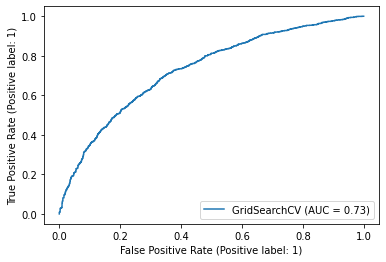

In [42]:
param_grid = dict(solver=['newton-cg', 'lbfgs', 'sag', 'saga'])
logreg_clf = LogisticRegression(penalty='none', max_iter=200,
                               random_state=0)
logreg_gscv = GridSearchCV(estimator=logreg_clf, param_grid=param_grid)
logreg_gscv.fit(X_train, y_train)
model_eval(logreg_gscv)

#### Lasso

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Mean cross-validated score of the best_estimator: 0.685
Accuracy on test data: 0.674
              precision    recall  f1-score   support

           0       0.65      0.56      0.60      1111
           1       0.69      0.77      0.73      1426

    accuracy                           0.67      2537
   macro avg       0.67      0.66      0.66      2537
weighted avg       0.67      0.67      0.67      2537

Tuned Model Parameters: {'C': 1, 'solver': 'saga'}


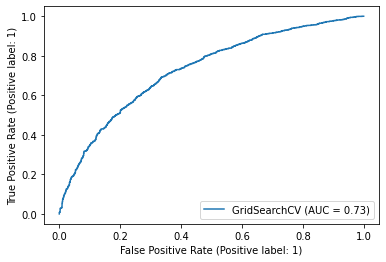

In [43]:
param_grid = dict(C=[10 ** x for x in range(-1, 2)], 
                 solver=['liblinear', 'saga'])
lasso_clf = LogisticRegression(penalty='l1', max_iter=200,
                               random_state=0)
lasso_gscv = GridSearchCV(estimator=lasso_clf, param_grid=param_grid)
lasso_gscv.fit(X_train, y_train)
model_eval(lasso_gscv)

#### Ridge

Mean cross-validated score of the best_estimator: 0.685
Accuracy on test data: 0.674
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      1111
           1       0.69      0.77      0.73      1426

    accuracy                           0.67      2537
   macro avg       0.67      0.66      0.66      2537
weighted avg       0.67      0.67      0.67      2537

Tuned Model Parameters: {'C': 0.1, 'solver': 'newton-cg'}


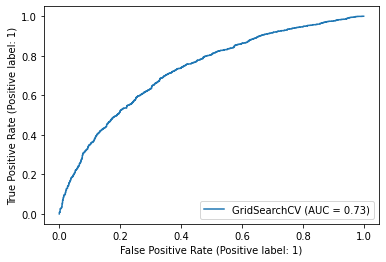

In [44]:
param_grid = dict(C=[10 ** x for x in range(-1, 2)],
                 solver=['newton-cg', 'lbfgs', 'sag', 'saga'])
ridge_clf = LogisticRegression(penalty='l2', max_iter=200,
                               random_state=0)
ridge_gscv = GridSearchCV(estimator=ridge_clf, param_grid=param_grid)
ridge_gscv.fit(X_train, y_train)
model_eval(ridge_gscv)

#### Elastic net

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Mean cross-validated score of the best_estimator: 0.685
Accuracy on test data: 0.674
              precision    recall  f1-score   support

           0       0.65      0.56      0.60      1111
           1       0.69      0.77      0.73      1426

    accuracy                           0.67      2537
   macro avg       0.67      0.66      0.66      2537
weighted avg       0.67      0.67      0.67      2537

Tuned Model Parameters: {'C': 1, 'l1_ratio': 0.8}


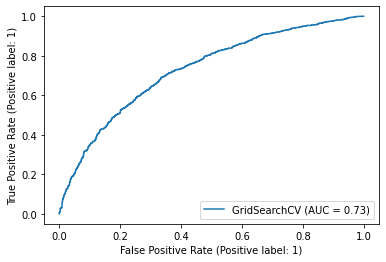

In [45]:
param_grid = dict(C=[10 ** x for x in range(-1, 2)],
                 l1_ratio=[0.2, 0.5, 0.8])
elastic_clf = LogisticRegression(penalty='elasticnet', max_iter=200,
                               solver='saga', random_state=0)
elastic_gscv = GridSearchCV(estimator=elastic_clf, param_grid=param_grid)
elastic_gscv.fit(X_train, y_train)
model_eval(elastic_gscv)

All the logistic regression models have the same accuracy no matter which penalty and which set of parameter are used. Let's switch to other models.

### Decision Tree

Mean cross-validated score of the best_estimator: 0.684
Accuracy on test data: 0.686
              precision    recall  f1-score   support

           0       0.70      0.49      0.58      1111
           1       0.68      0.84      0.75      1426

    accuracy                           0.69      2537
   macro avg       0.69      0.66      0.66      2537
weighted avg       0.69      0.69      0.67      2537

Tuned Model Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


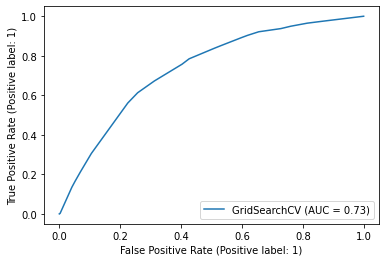

In [46]:
param_grid = dict(
    criterion=['gini', 'entropy'],
    min_samples_split=[2, 10],
    max_depth=[5, 10],
    min_samples_leaf=[1, 10],
    max_leaf_nodes=[10, 20])
dt_gscv = GridSearchCV(DecisionTreeClassifier(random_state=0), 
                       param_grid, scoring='accuracy')
dt_gscv.fit(X_train, y_train)
model_eval(dt_gscv)

### Naive Bayes

#### Gaussian Naive Bayes

Mean cross-validated score of the best_estimator: 0.636
Accuracy on test data: 0.637
              precision    recall  f1-score   support

           0       0.58      0.63      0.60      1111
           1       0.69      0.64      0.67      1426

    accuracy                           0.64      2537
   macro avg       0.63      0.64      0.63      2537
weighted avg       0.64      0.64      0.64      2537

Tuned Model Parameters: {}


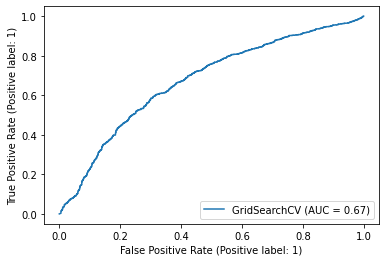

In [47]:
gnb = GaussianNB()
params = {}
gnb_gscv = GridSearchCV(gnb, params)
gnb_gscv.fit(X_train, y_train)
model_eval(gnb_gscv)

#### Bernoulli Naive Bayes

Mean cross-validated score of the best_estimator: 0.657
Accuracy on test data: 0.655
              precision    recall  f1-score   support

           0       0.61      0.58      0.60      1111
           1       0.69      0.71      0.70      1426

    accuracy                           0.65      2537
   macro avg       0.65      0.65      0.65      2537
weighted avg       0.65      0.65      0.65      2537

Tuned Model Parameters: {'alpha': 1}


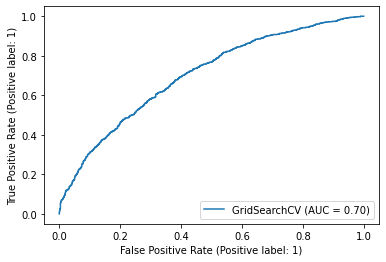

In [48]:
bnb = BernoulliNB()
param_grid = dict(alpha=[0.1, 0.3, 0.9, 1])
bnb_gscv = GridSearchCV(bnb, param_grid)
bnb_gscv.fit(X_train, y_train)
model_eval(bnb_gscv)

### K-nearest Neighbor

Mean cross-validated score of the best_estimator: 0.722
Accuracy on test data: 0.732
              precision    recall  f1-score   support

           0       0.75      0.59      0.66      1111
           1       0.72      0.84      0.78      1426

    accuracy                           0.73      2537
   macro avg       0.74      0.72      0.72      2537
weighted avg       0.73      0.73      0.73      2537

Tuned Model Parameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}


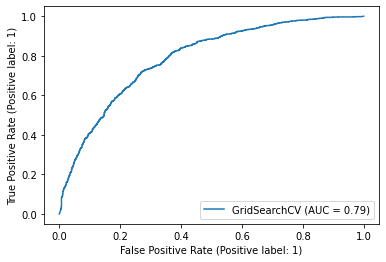

In [49]:
knn_clf = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_gscv = GridSearchCV(knn_clf, param_grid=param_grid)
knn_gscv.fit(X_train, y_train)
model_eval(knn_gscv)

### Linear SVM

Mean cross-validated score of the best_estimator: 0.685
Accuracy on test data: 0.672
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      1111
           1       0.69      0.77      0.72      1426

    accuracy                           0.67      2537
   macro avg       0.67      0.66      0.66      2537
weighted avg       0.67      0.67      0.67      2537

Tuned Model Parameters: {'C': 1}


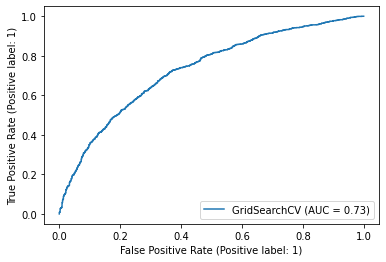

In [50]:
param_grid = dict(C=[0.1, 1, 10, 100])
linear_svc = LinearSVC(max_iter=5000, dual=False)
linear_svc_gscv = GridSearchCV(estimator=linear_svc, param_grid=param_grid)
linear_svc_gscv.fit(X_train, y_train)
model_eval(linear_svc_gscv)

| Model | Validation Accuracy|Testing Accuracy|AUC|
|-------|---------|-------|-----------|
|Logistic Regression with No Penalty|0.683|0.673|0.73|
|Lasso Logistic Regression|0.685|0.674|0.73|
|Ridge Logistic Regression|0.685|0.674|0.73|
|Elasticnet Logistic Regression|0.685|0.674|0.73|
|Decision Tree|0.684|0.686|0.73|
|Gaussian Naive Bayes|0.636|0.637|0.67|
|Bernoulli Naive Bayes|0.657|0.655|0.67|
|KNN Classifier|**0.722**|**0.732**|**0.79**|
|Linear SVM|0.685|0.672|0.73|

Those are models that are fast to train, for now, knn classifier and decision tree have the highest accuracy. It indicates that ensemble tree models might have a good performance on the dataset. As for advanced models, we will choose polynomial SVM, Gaussian RBF SVM, random forest, XGBoost, and lightGBM. Before that, we decide to apply PCA for dimension reduction then re-train those basic models to see if there will be any improvement in performance. Given the fact that are validation accuracy and test accuracy are close, PCA may not be able to improve the results.

## Dimension Reduction

### PCA

Let's start with PCA with 95% variance explained:

In [51]:
pca = PCA(n_components=0.95, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [52]:
pca.explained_variance_ratio_

array([0.12811801, 0.09754978, 0.08551411, 0.06789102, 0.05521497,
       0.05447747, 0.05097969, 0.04791053, 0.04489316, 0.03917589,
       0.02995311, 0.02978655, 0.02759628, 0.02581459, 0.0233462 ,
       0.01662535, 0.01464553, 0.01391491, 0.01264744, 0.01093939,
       0.01057137, 0.01017765, 0.00889275, 0.00807305, 0.00776118,
       0.00708382, 0.00648027, 0.00613311, 0.00582614, 0.00538927])

To explain 95% variance of the original data, PCA reduced the dimension from 66 to 29. We can try kernel PCA to see if the kernel trick can help us reduce the dimension even more.

### Gaussian RBF PCA

In [53]:
# gamma is set to None by default, which means gamma = 1/n_features
rbf_pca = KernelPCA(n_components=20, kernel='rbf')
X_train_rbf_pca = rbf_pca.fit_transform(X_train)
X_test_rbf_pca = rbf_pca.transform(X_test)

Now we can re-train the basic models to see if there are any performance improvement. This time we pick **logistic regression with l2 penalty, decision tree, Bernoulli Naive Bayes, knn classifier,** and **linear SVM**.

## Re-train Basic Models After Dimension Reduction

#### Logistic Regression with l2 penalty

Mean cross-validated score of the best_estimator: 0.679
Accuracy on test data: 0.671
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      1111
           1       0.69      0.76      0.72      1426

    accuracy                           0.67      2537
   macro avg       0.67      0.66      0.66      2537
weighted avg       0.67      0.67      0.67      2537

Tuned Model Parameters: {'C': 0.1, 'solver': 'newton-cg'}


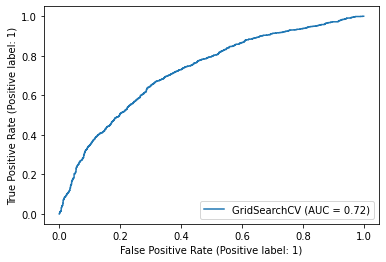

In [54]:
param_grid = dict(C=[10 ** x for x in range(-1, 2)],
                 solver=['newton-cg', 'lbfgs', 'sag', 'saga'])
ridge_clf = LogisticRegression(penalty='l2', max_iter=200,
                               random_state=0)
ridge_pca_gscv = GridSearchCV(estimator=ridge_clf, param_grid=param_grid)
ridge_pca_gscv.fit(X_train_pca, y_train)
model_eval(ridge_pca_gscv, X_test_pca, y_test)

Mean cross-validated score of the best_estimator: 0.643
Accuracy on test data: 0.633
              precision    recall  f1-score   support

           0       0.61      0.46      0.52      1111
           1       0.65      0.77      0.70      1426

    accuracy                           0.63      2537
   macro avg       0.63      0.61      0.61      2537
weighted avg       0.63      0.63      0.62      2537

Tuned Model Parameters: {'C': 10, 'solver': 'sag'}


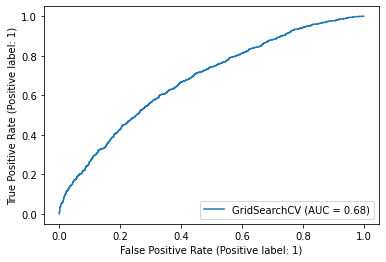

In [55]:
param_grid = dict(C=[10 ** x for x in range(-1, 2)],
                 solver=['newton-cg', 'lbfgs', 'sag', 'saga'])
ridge_clf = LogisticRegression(penalty='l2', max_iter=200,
                               random_state=0)
ridge_rbf_pca_gscv = GridSearchCV(estimator=ridge_clf, param_grid=param_grid)
ridge_rbf_pca_gscv.fit(X_train_rbf_pca, y_train)
model_eval(ridge_rbf_pca_gscv, X_test_rbf_pca, y_test)

#### Decision Tree

Mean cross-validated score of the best_estimator: 0.650
Accuracy on test data: 0.648
              precision    recall  f1-score   support

           0       0.61      0.56      0.58      1111
           1       0.68      0.72      0.70      1426

    accuracy                           0.65      2537
   macro avg       0.64      0.64      0.64      2537
weighted avg       0.65      0.65      0.65      2537

Tuned Model Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


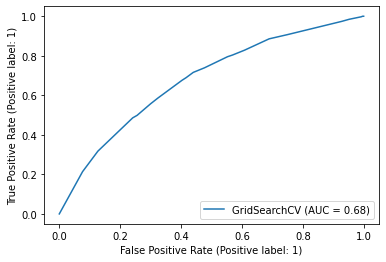

In [56]:
param_grid = dict(
    criterion=['gini', 'entropy'],
    min_samples_split=[2, 10],
    max_depth=[5, 10],
    min_samples_leaf=[1, 10],
    max_leaf_nodes=[10, 20])
dt_pca_gscv = GridSearchCV(DecisionTreeClassifier(random_state=0), 
                       param_grid, scoring='accuracy')
dt_pca_gscv.fit(X_train_pca, y_train)
model_eval(dt_pca_gscv, X_test_pca, y_test)

Mean cross-validated score of the best_estimator: 0.650
Accuracy on test data: 0.641
              precision    recall  f1-score   support

           0       0.61      0.50      0.55      1111
           1       0.66      0.75      0.70      1426

    accuracy                           0.64      2537
   macro avg       0.63      0.63      0.63      2537
weighted avg       0.64      0.64      0.64      2537

Tuned Model Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


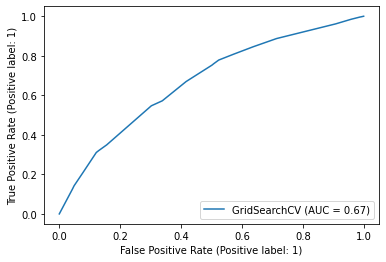

In [57]:
param_grid = dict(
    criterion=['gini', 'entropy'],
    min_samples_split=[2, 10],
    max_depth=[5, 10],
    min_samples_leaf=[1, 10],
    max_leaf_nodes=[10, 20])
dt_rbf_pca_gscv = GridSearchCV(DecisionTreeClassifier(random_state=0), 
                       param_grid, scoring='accuracy')
dt_rbf_pca_gscv.fit(X_train_rbf_pca, y_train)
model_eval(dt_rbf_pca_gscv, X_test_rbf_pca, y_test)

#### Bernoulli Naive Bayes

Mean cross-validated score of the best_estimator: 0.651
Accuracy on test data: 0.637
              precision    recall  f1-score   support

           0       0.61      0.48      0.54      1111
           1       0.65      0.76      0.70      1426

    accuracy                           0.64      2537
   macro avg       0.63      0.62      0.62      2537
weighted avg       0.63      0.64      0.63      2537

Tuned Model Parameters: {'alpha': 0.1}


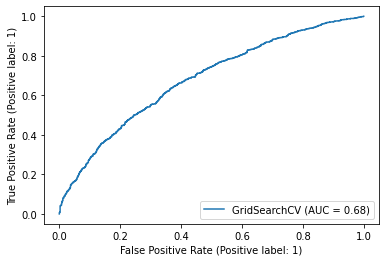

In [58]:
bnb = BernoulliNB()
param_grid = dict(alpha=[0.1, 0.3, 0.9, 1])
bnb_pca_gscv = GridSearchCV(bnb, param_grid)
bnb_pca_gscv.fit(X_train_pca, y_train)
model_eval(bnb_pca_gscv, X_test_pca, y_test)

Mean cross-validated score of the best_estimator: 0.637
Accuracy on test data: 0.633
              precision    recall  f1-score   support

           0       0.61      0.45      0.52      1111
           1       0.64      0.78      0.70      1426

    accuracy                           0.63      2537
   macro avg       0.63      0.61      0.61      2537
weighted avg       0.63      0.63      0.62      2537

Tuned Model Parameters: {'alpha': 0.1}


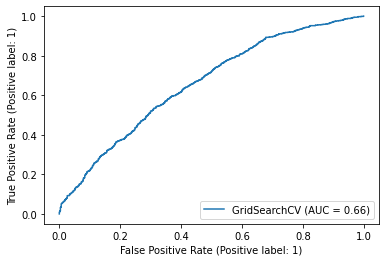

In [59]:
bnb = BernoulliNB()
param_grid = dict(alpha=[0.1, 0.3, 0.9, 1])
bnb_rbf_pca_gscv = GridSearchCV(bnb, param_grid)
bnb_rbf_pca_gscv.fit(X_train_rbf_pca, y_train)
model_eval(bnb_rbf_pca_gscv, X_test_rbf_pca, y_test)

#### Knn classifier

Mean cross-validated score of the best_estimator: 0.722
Accuracy on test data: 0.720
              precision    recall  f1-score   support

           0       0.73      0.57      0.64      1111
           1       0.71      0.84      0.77      1426

    accuracy                           0.72      2537
   macro avg       0.72      0.70      0.71      2537
weighted avg       0.72      0.72      0.71      2537

Tuned Model Parameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}


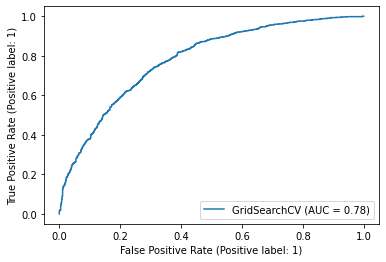

In [60]:
knn_clf = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_pca_gscv = GridSearchCV(knn_clf, param_grid=param_grid)
knn_pca_gscv.fit(X_train_pca, y_train)
model_eval(knn_pca_gscv, X_test_pca, y_test)

Mean cross-validated score of the best_estimator: 0.697
Accuracy on test data: 0.704
              precision    recall  f1-score   support

           0       0.71      0.55      0.62      1111
           1       0.70      0.83      0.76      1426

    accuracy                           0.70      2537
   macro avg       0.71      0.69      0.69      2537
weighted avg       0.71      0.70      0.70      2537

Tuned Model Parameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}


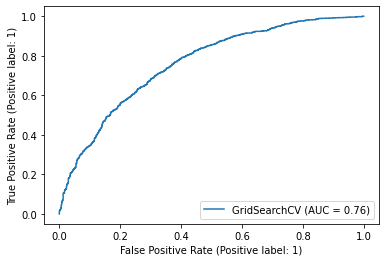

In [61]:
knn_clf = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_rbf_pca_gscv = GridSearchCV(knn_clf, param_grid=param_grid)
knn_rbf_pca_gscv.fit(X_train_rbf_pca, y_train)
model_eval(knn_rbf_pca_gscv, X_test_rbf_pca, y_test)

#### Linear SVM

Mean cross-validated score of the best_estimator: 0.679
Accuracy on test data: 0.672
              precision    recall  f1-score   support

           0       0.65      0.56      0.60      1111
           1       0.69      0.76      0.72      1426

    accuracy                           0.67      2537
   macro avg       0.67      0.66      0.66      2537
weighted avg       0.67      0.67      0.67      2537

Tuned Model Parameters: {'C': 0.1}


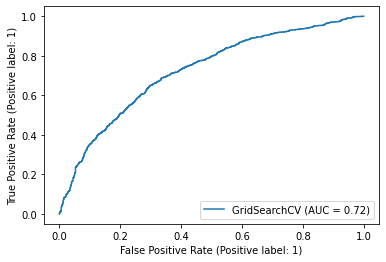

In [62]:
param_grid = dict(C=[0.1, 1, 10, 100])
linear_svc = LinearSVC(max_iter=5000, dual=False)
linear_svc_pca_gscv = GridSearchCV(estimator=linear_svc, param_grid=param_grid)
linear_svc_pca_gscv.fit(X_train_pca, y_train)
model_eval(linear_svc_pca_gscv, X_test_pca, y_test)

Mean cross-validated score of the best_estimator: 0.643
Accuracy on test data: 0.632
              precision    recall  f1-score   support

           0       0.61      0.46      0.52      1111
           1       0.65      0.77      0.70      1426

    accuracy                           0.63      2537
   macro avg       0.63      0.61      0.61      2537
weighted avg       0.63      0.63      0.62      2537

Tuned Model Parameters: {'C': 100}


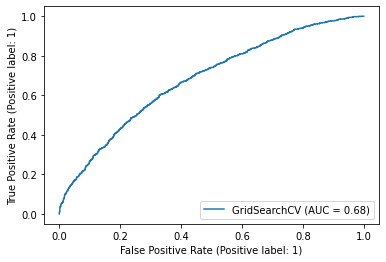

In [63]:
param_grid = dict(C=[0.1, 1, 10, 100])
linear_svc = LinearSVC(max_iter=5000, dual=False)
linear_svc_rbf_pca_gscv = GridSearchCV(estimator=linear_svc, param_grid=param_grid)
linear_svc_rbf_pca_gscv.fit(X_train_rbf_pca, y_train)
model_eval(linear_svc_rbf_pca_gscv, X_test_rbf_pca, y_test)

Now, we have finished re-train models on PCA and kernel PCA with Gaussian RBF. Let's compare the results:

| Model | Validation Accuracy on Normal Data |Testing Accuracy on Normal Data| Validation Accuracy After PCA | Testing Accuracy After PCA | Validation Accuracy After Gaussian RBF PCA | Testing Accuracy After Gaussian RBF PCA |
|-------|---------|-------|-----------|------|------|------|
|Ridge Logistic Regression|**0.685**|**0.674**|0.679|0.671|0.643|0.633|
|Decision Tree|**0.684**|**0.686**|0.650|0.648|0.650|0.641|
|Bernoulli Naive Bayes|**0.657**|**0.655**|0.651|0.637|0.637|0.633|
|KNN Classifier|**0.722**|**0.732**|0.722|0.720|0.704|0.697|
|Linear SVM|**0.685**|**0.672**|0.679|0.672|0.643|0.632|

All the dimension reduced results were outperformed by the models on normal data. As we mentioned before, validation scores and testing scores are close, so, no overfitting. In this case, dimension reduction is not that useful. To improve the prediction results, we still have two directions to explore: 
* Feature Expansion

We can use clustering method to cluster the training data and add the cluster label as new feature.

* Advanced Models

Advanced models like random forest, kernel SVM, gradient boosting trees can be applied.

## Feature Expansion

### K-prototypes Clustering

Since we have mixed data types, K-means is not appropriate here because Euclidean distance is meaningless for categorical data. There are two variations of K-means clustering: K-modes is capable of clustering on categorical data, K-prototypes clustering is suitable for mixed data types. Both of them are encapsulated in **kmodes** module.

There is a question for the clustering algorithm: include the target feature or not. If we include the target feature, although the data leakage will be diluted through the clustering process, the classification cannot be finished until we get test data of the target. That is meaningless for a classification algorithm, if a model can only answer a question until it get the anwer of the question, why bother building that model? We can just look at the answer. Thus, we will apply clustering to the training set without the target, add the cluster label as a new feature, and predict the cluster label for the test set using the same centroids.

To determine which number of clusters to use in the K-prototypes clustering, we plotted a silhouette diagram:

In [64]:
kprot_per_k = [KModes(n_clusters=k, random_state=0, n_jobs=-1).fit(X_train) 
               for k in range(1, 11)]

In [65]:
silhouette_scores = [silhouette_score(X_train, model.labels_)
                     for model in kprot_per_k[1:]]

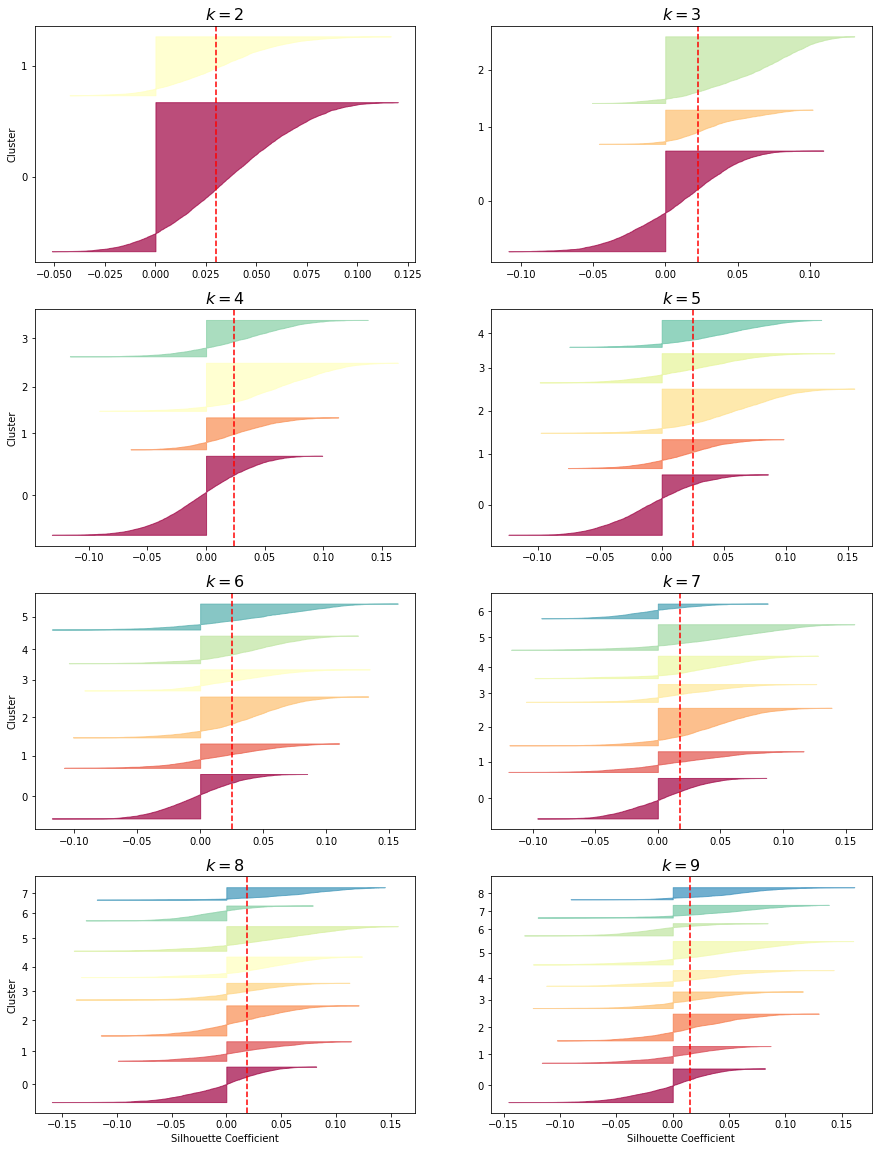

In [66]:
plt.figure(figsize=(15, 20))
for k in range(2, 10):
    plt.subplot(4, 2, k - 1)
        
    y_pred = kprot_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_train, y_pred)

    padding = len(X_train) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 4, 6, 8):
        plt.ylabel("Cluster")
    
    if k in (8, 9):
        plt.xlabel("Silhouette Coefficient")

    plt.axvline(x=silhouette_scores[k - 1], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

In [67]:
silhouette_scores

[0.03591472480321095,
 0.029929847965832417,
 0.02291236163917013,
 0.023554023488186544,
 0.025431488057714353,
 0.02562259021640688,
 0.01740727447865894,
 0.018651826802484412,
 0.01524675909303155]

Silhouette coefficient ranges from -1 to +1, the silhouette score is the mean silhouette coefficient over all the instances within the cluster. A coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to –1 means that the instance may have been assigned to the wrong cluster.

According to the silhouette plot, the silhouette score looks okay only when k = 2. All the silhouette scores are low, indicates the instances are at the boundary of clusters, and it become even worse for those higher ks with negatively long tail indicating wrong cluster assignments.

So, we are picking k=2 as the number of clusters of our K-prototypes clusering.

In [68]:
kprot_2 = KModes(n_clusters=2, random_state=0, n_jobs=-1).fit(X_train)
X_train_kprot = pd.DataFrame(X_train)
X_train_kprot['cluster'] = kprot_2.labels_
X_test_kprot = pd.DataFrame(X_test)
X_test_kprot['cluster'] = kprot_2.predict(X_test)

## Retrain Models after Adding Cluster Labels

Now, we retrain the 5 models used in dimension reduction to see if there is any improvement:

Mean cross-validated score of the best_estimator: 0.684
Accuracy on test data: 0.674
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      1111
           1       0.69      0.77      0.73      1426

    accuracy                           0.67      2537
   macro avg       0.67      0.66      0.66      2537
weighted avg       0.67      0.67      0.67      2537

Tuned Model Parameters: {'C': 0.1, 'solver': 'sag'}


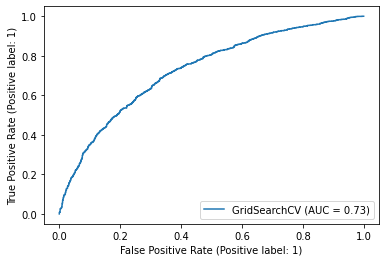

In [69]:
param_grid = dict(C=[10 ** x for x in range(-1, 2)],
                 solver=['newton-cg', 'lbfgs', 'sag', 'saga'])
ridge_clf = LogisticRegression(penalty='l2', max_iter=200,
                               random_state=0)
ridge_kprot_gscv = GridSearchCV(estimator=ridge_clf, param_grid=param_grid)
ridge_kprot_gscv.fit(X_train_kprot, y_train)
model_eval(ridge_kprot_gscv, X_test_kprot, y_test)

Mean cross-validated score of the best_estimator: 0.684
Accuracy on test data: 0.686
              precision    recall  f1-score   support

           0       0.70      0.49      0.58      1111
           1       0.68      0.84      0.75      1426

    accuracy                           0.69      2537
   macro avg       0.69      0.66      0.66      2537
weighted avg       0.69      0.69      0.67      2537

Tuned Model Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


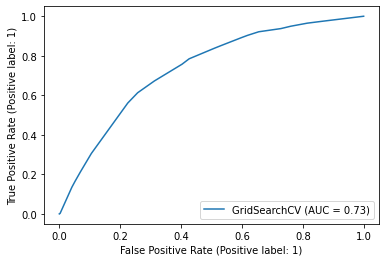

In [70]:
param_grid = dict(
    criterion=['gini', 'entropy'],
    min_samples_split=[2, 10],
    max_depth=[5, 10],
    min_samples_leaf=[1, 10],
    max_leaf_nodes=[10, 20])
dt_kprot_gscv = GridSearchCV(DecisionTreeClassifier(random_state=0), 
                             param_grid, scoring='accuracy')
dt_kprot_gscv.fit(X_train_kprot, y_train)
model_eval(dt_kprot_gscv, X_test_kprot, y_test)

Mean cross-validated score of the best_estimator: 0.652
Accuracy on test data: 0.644
              precision    recall  f1-score   support

           0       0.60      0.57      0.58      1111
           1       0.68      0.70      0.69      1426

    accuracy                           0.64      2537
   macro avg       0.64      0.64      0.64      2537
weighted avg       0.64      0.64      0.64      2537

Tuned Model Parameters: {'alpha': 0.1}


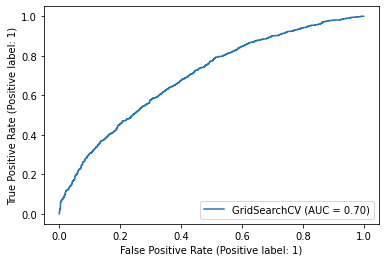

In [71]:
bnb = BernoulliNB()
param_grid = dict(alpha=[0.1, 0.3, 0.9, 1])
bnb_kprot_gscv = GridSearchCV(bnb, param_grid)
bnb_kprot_gscv.fit(X_train_kprot, y_train)
model_eval(bnb_kprot_gscv, X_test_kprot, y_test)

Mean cross-validated score of the best_estimator: 0.720
Accuracy on test data: 0.730
              precision    recall  f1-score   support

           0       0.75      0.58      0.65      1111
           1       0.72      0.85      0.78      1426

    accuracy                           0.73      2537
   macro avg       0.73      0.71      0.72      2537
weighted avg       0.73      0.73      0.72      2537

Tuned Model Parameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}


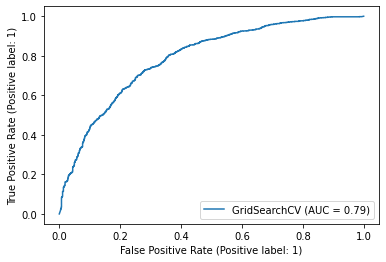

In [72]:
knn_clf = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_kprot_gscv = GridSearchCV(knn_clf, param_grid=param_grid)
knn_kprot_gscv.fit(X_train_kprot, y_train)
model_eval(knn_kprot_gscv, X_test_kprot, y_test)

Mean cross-validated score of the best_estimator: 0.685
Accuracy on test data: 0.673
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      1111
           1       0.69      0.77      0.72      1426

    accuracy                           0.67      2537
   macro avg       0.67      0.66      0.66      2537
weighted avg       0.67      0.67      0.67      2537

Tuned Model Parameters: {'C': 0.1}


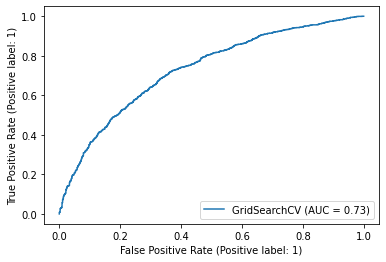

In [73]:
param_grid = dict(C=[0.1, 1, 10, 100])
linear_svc = LinearSVC(max_iter=5000, dual=False)
linear_svc_kprot_gscv = GridSearchCV(estimator=linear_svc, param_grid=param_grid)
linear_svc_kprot_gscv.fit(X_train_kprot, y_train)
model_eval(linear_svc_kprot_gscv, X_test_kprot, y_test)

| Model | Validation Accuracy|Testing Accuracy|AUC|Validation Accuracy after Adding Clusters|Testing Accuracy after Adding Clusters|AUC after Adding Clusters|
|-------|---------|-------|-----------|----|---|---|
|Ridge Logistic Regression|0.685|0.674|0.73|0.684|0.674|0.73|
|Decision Tree|0.684|0.686|0.73|0.684|0.686|0.73|
|Bernoulli Naive Bayes|0.657|0.655|0.67|0.652|0.644|**0.70**|
|KNN Classifier|0.722|0.732|0.79|0.720|0.730|0.79|
|Linear SVM|0.685|0.672|0.73|0.685|**0.673**|0.73|

Unfortunately, only testing accuracy on linear SVM improved by 0.001 and the AUC of Bernoulli Naive Bayes improved by 0.03. That means our feature expansion by clustering is a fail.

Besides, there are other methods to consider: 
1. Adding polynomial features

However, adding polynomial features on categorical data seems making no sense.

2. Adding similarity features

We can also adding similarity features such as Gaussian RBF, but that will explosively increase the data size from about 10,000 * 70 to 10,000 * 10,000, which will be too computationally expensive for us.

Thus, we decide to stick with the original data.

## Advanced Models

Now, we are going to apply on the original data kernel SVM, random forest, and gradient boosting trees.

In [74]:
def model_eval_new(clf, X_test=X_test, y_test=y_test):
    y_pred = clf.predict(X_test)
    print("Mean cross-validated score of the best_estimator: {0:.3f}".format(clf.best_score_))
    print("Accuracy on test data: {0:.3f}".format(clf.score(X_test, y_test)))
    print(metrics.classification_report(y_test, y_pred))
    print("Tuned Model Parameters: {}".format(clf.best_params_))
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    metrics.plot_roc_curve(clf, X_test, y_test)
    plt.show()

### Polynomial SVM

Kernel tricks in SVM make it possible to get the same result as if we had added many non-linear features like by polynomial or Gaussian RBF, without actually having to add them. However, with our training data, the running time will be quite long.

Mean cross-validated score of the best_estimator: 0.748
Accuracy on test data: 0.747
              precision    recall  f1-score   support

           0       0.75      0.63      0.69      1111
           1       0.75      0.84      0.79      1426

    accuracy                           0.75      2537
   macro avg       0.75      0.73      0.74      2537
weighted avg       0.75      0.75      0.74      2537

Tuned Model Parameters: {'C': 1, 'degree': 4}


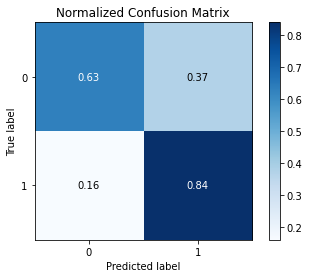

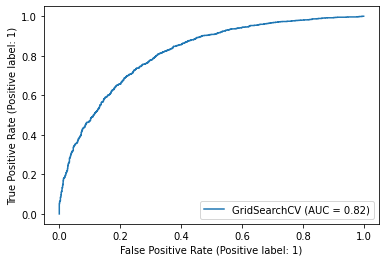

In [75]:
poly_svc = SVC(kernel='poly')
param_grid = dict(C=[0.1, 1, 10], 
                  degree=[2, 4, 10])
poly_svc_gscv = GridSearchCV(poly_svc, param_grid)
poly_svc_gscv.fit(X_train, y_train)
model_eval_new(poly_svc_gscv)

### Gaussian RBF SVM

Mean cross-validated score of the best_estimator: 0.748
Accuracy on test data: 0.754
              precision    recall  f1-score   support

           0       0.75      0.65      0.70      1111
           1       0.75      0.83      0.79      1426

    accuracy                           0.75      2537
   macro avg       0.75      0.74      0.75      2537
weighted avg       0.75      0.75      0.75      2537

Tuned Model Parameters: {'C': 1, 'gamma': 0.1}


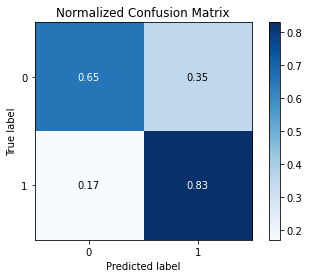

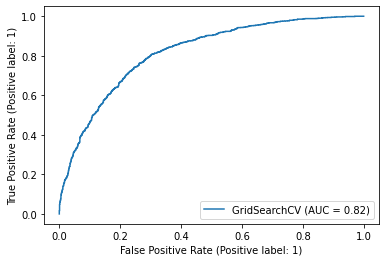

In [76]:
rbf_svc = SVC(kernel='rbf')
param_grid = dict(C=[0.1, 1, 10],
                  gamma=[0.1, 1, 2])
rbf_svc_gscv = GridSearchCV(rbf_svc, param_grid)
rbf_svc_gscv.fit(X_train, y_train)
model_eval_new(rbf_svc_gscv)

### Random Forest

Mean cross-validated score of the best_estimator: 0.752
Accuracy on test data: 0.749
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      1111
           1       0.75      0.83      0.79      1426

    accuracy                           0.75      2537
   macro avg       0.75      0.74      0.74      2537
weighted avg       0.75      0.75      0.75      2537

Tuned Model Parameters: {'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}


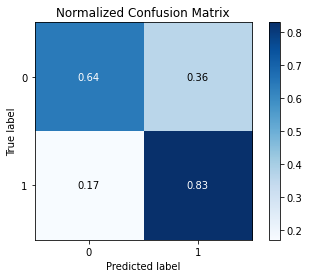

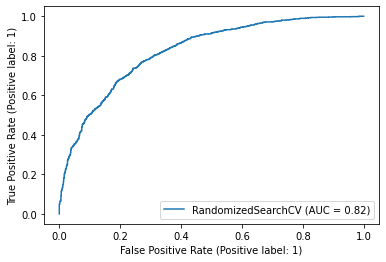

In [77]:
rf = RandomForestClassifier(random_state=0)
random_grid = dict(n_estimators=[1000, 1400],
                   max_depth=[20, 30],
                   min_samples_split=[2, 5],
                   min_samples_leaf=[1, 2])
rf_rscv = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,\
                             cv=5, random_state=0)
rf_rscv.fit(X_train, y_train)
model_eval_new(rf_rscv)

### XGBoost

XGBoost is the called Extreme Gradient Boosting, a popular and fast Gradient Boosting Machine. It is often an important component of the winning entries in machine learning competitions. Its API is quite similar to Scikit-Learn's.

Mean cross-validated score of the best_estimator: 0.764
Accuracy on test data: 0.765
              precision    recall  f1-score   support

           0       0.75      0.69      0.72      1111
           1       0.77      0.82      0.80      1426

    accuracy                           0.76      2537
   macro avg       0.76      0.76      0.76      2537
weighted avg       0.76      0.76      0.76      2537

Tuned Model Parameters: {'eta': 0.2, 'gamma': 0.2, 'max_depth': 12, 'min_child_weight': 3}


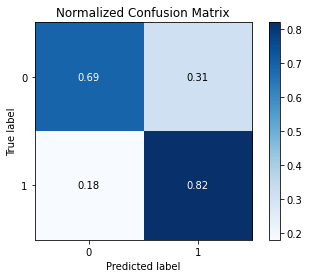

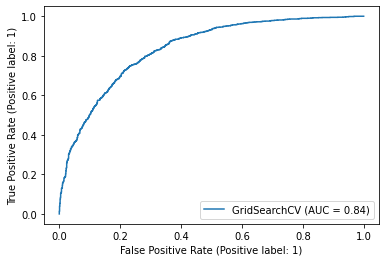

In [78]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', 
                            use_label_encoder=False)
param_grid = dict(eta=[0.10, 0.20],
                  max_depth=[3, 8, 12],
                  min_child_weight=[1, 3],
                  gamma=[0.2, 0.4])
xgb_gscv = GridSearchCV(xgb_clf, param_grid)
xgb_gscv.fit(X_train, y_train)
model_eval_new(xgb_gscv)

### LightGBM

LightGBM or light Gradient Boosting Machine, is a gradient boosting package developed by Microsoft, it has great support for categorical data. 

Mean cross-validated score of the best_estimator: 0.763
Accuracy on test data: 0.766
              precision    recall  f1-score   support

           0       0.76      0.69      0.72      1111
           1       0.77      0.83      0.80      1426

    accuracy                           0.77      2537
   macro avg       0.76      0.76      0.76      2537
weighted avg       0.77      0.77      0.76      2537

Tuned Model Parameters: {'learning_rate': 0.3, 'num_leaves': 127}


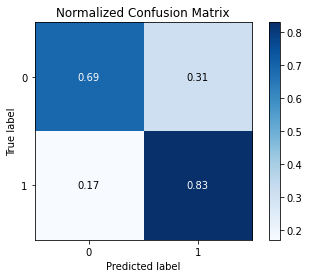

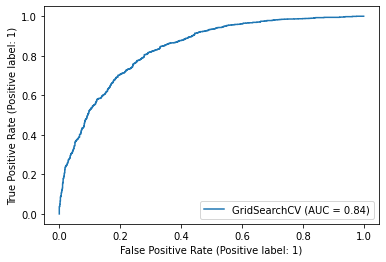

In [79]:
lgb_clf = lgb.LGBMClassifier(objective='binary', metric='binary_logloss')
param_grid = dict(learning_rate=[0.10, 0.30],
                  num_leaves=[31, 127, 255])
lgb_gscv = GridSearchCV(lgb_clf, param_grid)
lgb_gscv.fit(X_train, y_train)
model_eval_new(lgb_gscv)

### CatBoost

CatBoost is another gradient boosting decison trees package developed by Yandex. It has good support for categorical features, and best in class prediction speed.

Mean cross-validated score of the best_estimator: 0.770
Accuracy on test data: 0.771
              precision    recall  f1-score   support

           0       0.77      0.68      0.72      1111
           1       0.77      0.85      0.81      1426

    accuracy                           0.77      2537
   macro avg       0.77      0.76      0.76      2537
weighted avg       0.77      0.77      0.77      2537

Tuned Model Parameters: {'depth': 8}


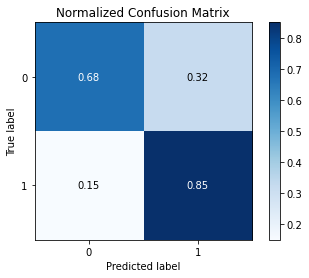

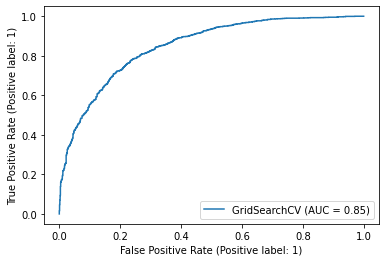

In [80]:
cat_clf = CatBoostClassifier(random_seed=0, loss_function='Logloss', 
                             logging_level='Silent')
param_grid = dict(depth=[4, 6, 8, 12])
cat_gscv = GridSearchCV(cat_clf, param_grid)
cat_gscv.fit(X_train, y_train)
model_eval_new(cat_gscv)

CatBoost achieved the highest accuracy so far.

Let's compare the results given by those advanced models:

| Model | Validation Accuracy|Testing Accuracy|AUC|
|-------|---------|-------|-----------|
|Polynomial SVM|0.748|0.747|0.82|
|Gaussian RBF SVM|0.748|0.754|0.82|
|Bernoulli Naive Bayes|0.752|0.749|0.82|
|XGBoost|0.764|0.765|0.84|
|lightGBM|0.763|0.766|0.84|
|CatBoost|**0.770**|**0.771**|**0.85**|

# Model Stacking

There is one more thing we can do to push the accuracy even higher. It is an ensemble method called stacked generalization, or stacking in short. Recall that in ensemble models we used some trival functions like simple voting to aggregate the predictions of all predictors in an ensemble, stacking is right on top of this idea. In stead of using trivial functions, stacking train a model to perform the aggregation. 

Stacking consists of two parts: base models and meta model. Base models are lower level predictors, meta model blend the prediction given by base models into a final prediction.

In [81]:
models_dict = dict(
    XGBoost=xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',
                              use_label_encoder=False, eta=0.2, gamma=0.2, 
                              max_depth=12, min_child_weight=3),
    lightGBM=lgb.LGBMClassifier(objective='binary', metric='binary_logloss',
                                learning_rate=0.3, num_leaves=127),
    CatBoost=CatBoostClassifier(random_seed=0, loss_function='Logloss', 
                                logging_level='Silent', depth=8))

In [82]:
def evaluate_model(model, X=X_train, y=y_train):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)
    scores = cross_val_score(model, X, y, scoring='accuracy', 
                             cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [83]:
def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

In [84]:
model_scores = defaultdict()
for name, model in models_dict.items():
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, X_train, y_train)
    model_scores[name] = scores

Evaluating XGBoost
Evaluating lightGBM
Evaluating CatBoost


In [85]:
base_models = [('XGBoost', 
                xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', 
                                  use_label_encoder=False, eta=0.2, gamma=0.2, 
                                  max_depth=12, min_child_weight=3)),
               ('lightGBM', 
                lgb.LGBMClassifier(objective='binary', metric='binary_logloss',
                                   learning_rate=0.3, num_leaves=127)),
               ('CatBoost', CatBoostClassifier(random_seed=0, loss_function='Logloss', 
                                logging_level='Silent', depth=8))]
meta_model = LogisticRegressionCV()
stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5)

In [86]:
stacking_scores = evaluate_model(stacking_model, X_train, y_train)
model_scores['stacking'] = stacking_scores

In [87]:
plot_results(model_scores, name='stacking_model_cv')

According to the plot, the stacking model has a median validation accuracy of 77.26%, while CatBoost has a median accuracy of 77.14%, lightGBM's is 75.90%, XGBoost's is 75.81%. However, the stacking model costed one hour to train, while the Catboost model is trained in less than 10 minutes. In addition, the range of the accuracy of CatBoost model is smaller than the stacking model. Thus, CatBoost is the best model for this classification task.

# Conclusion

In this classification task, we started from data cleanning and exploratory data analysis, built basic models on original data, dimention reduced data, and featured expanded data to check which kind of data is best in improving model performance, then we trained advanced models like XGBoost, lightGBM, and CatBoost. Finally we explored if stacking is suitable for the task, which led to our final conclusion: for this classification task, CatBoost is the best model overall with respect to speed, accuracy, and stability.